In [2]:
from utils.visualizeGraph import draw_graph
from utils.getLLM import get_llm_embedings
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage,ToolMessage, SystemMessage, AnyMessage
from typing import Literal, Annotated
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnableMap
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel, Field
from langchain_core.messages import RemoveMessage
from operator import add
from langchain.schema.output_parser import StrOutputParser
from typing_extensions import TypedDict


In [28]:
class OverallState(TypedDict):
    processed_questions: Annotated[list[str], add_messages]
    orginal_question: Annotated[list[str], add]
    messages: Annotated[list[AnyMessage], add_messages]
    direction: str
    need_to_reload: Literal["yes", "no"]
    loop: Annotated[list[str], add] 
    store: Annotated[list[str], add] # if add_messages is taken it will return human message 
    needy_ques:str
    Final_Output:str

# Sub Agent Selector (PA)

In [29]:
class PAOutputParser(BaseModel):
    """
    Provides the agent name to be called based on the user's input.
    """
    SubAgent_names: Literal[
        "Interest_Charges_Handling_Agent",
        "Contact_Document_Handling_Agent",
        "General_Banking_Handling_Agent",
        "Bank_Details_Handling_Agent",
        "Appointment_Handling_Agent",
    ] = Field(description="The agent name that handles the user's request.")

    class Config:
        json_schema_extra = {
            "example": {
                "SubAgent_names": "Interest_Charges_Handling_Agent",
            }
        }


In [30]:
def subAgentSelector(overall_state:OverallState):

    llm = get_llm_embedings("open_ai")["llm"]

    system_prompt = """
        You are the Primary Agent responsible for analyzing user input to determine the user's intent. Based on the identified intent, you will route the user to the appropriate sub-agent to handle their request.

        There are 5 sub-agents available:

        1. Interest_Charges_Handling_Agent - 
            This sub-agent handles financial data related to savings deposits, loan products, and the 
            "Standard Tariff of Charges, 2081" from Muktinath Bikas Bank Ltd. It provides responses to 
            inquiries about interest rates, charges, and service fees associated with various banking 
            products, including savings accounts, fixed deposits, loans, and customer services.

            it covers two primary areas:
            a. Financial products, including savings deposits (e.g., highest and lowest interest rates, 
            minimum balance requirements, payment terms), call and current deposit accounts, 
            fixed deposits, loan products, microfinance loans, and general interest rate information.
            b. The "Standard Tariff of Charges, 2081" from Muktinath Bikas Bank Ltd., which includes 
            charges for customer services, banking services, credit facilities, loans, and special 
            provisions for bank staff, among other fees.\n\n


        2. Contact_Document_Handling_Agent -
            This sub-agent handles and manages contact information for multiple branches of Muktinath Bikas Bank 
            and provides details about the required documents for various banking services. It serves two primary 
            purposes:

            a. Branch Information: It can retrieve specific branch details such as the branch name, address, 
            district, phone number, and email address for Muktinath Bikas Bank branches. 
            Example queries could include asking for details about a specific branch or its location.
            b. Document Requirements: It provides information on the required documentation for opening different 
            types of bank accounts, applying for loans, and conducting transactions. This includes details on 
            identification, guarantor requirements, income verification, and compliance guidelines. It also covers 
            the types of online loan accounts and accounts that can be opened online. \n\n


        3. General_Banking_Handling_Agent  - 
           
            This sub-agent Handles general banking inquiries, covering various aspects of banking services, including:
            - Banking card-related information.
            - Digital banking services.
            - General loan-related queries (e.g., "What types of loans do you offer?").
            - FAQs and common banking inquiries.
            - Inclusive banking services.
            - Information about different banking products.
            - Details regarding savings accounts (Bachat Khata).

            
        4. Bank_Details_Handling_Agent - 

            This sub-agent handles all queries related to the bank. It addresses user inquiries about bank_info, leadership 
            (chairman, executive team, directors), departments of the bank (general, inclusive, digital), key contacts
            (CIO, complaints handling officer, compliance officer), committees (strategic committee), regional heads, 
            capital structure, contact email, general banking inquiries, banking hours.
           
            
        5. Appointment_Handling_Agent - Handles all queries related to bank appointments - 
            This tool is designed to provide responses to appointment-related 
            questions within the context of an online application process.

        
        """

    human_prompt = "Here is user input: {user_input}"

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", human_prompt)
    ])

    llm_with_parser = llm.with_structured_output(PAOutputParser)

    chain = RunnableMap({ "user_input": lambda x: x['user_input']}) | prompt | llm_with_parser

    result = chain.invoke({'user_input':overall_state['messages']})

    result = result.SubAgent_names

    return {"direction": result, "processed_questions": [HumanMessage(content=".",name="user")]}
                            


In [31]:
# direction = subAgentSelector({'messages':[HumanMessage(content=" who is ceo of bank ",name="user")]})

In [32]:
def PACondition(overall_state:OverallState):

      move_to = overall_state['direction']

      if move_to == "Interest_Charges_Handling_Agent":
        return "Is_Interest_Charges_Agent"
      
      elif move_to == "Contact_Document_Handling_Agent":
        return "Is_Contact_Document_Agent"
     
      elif move_to == "General_Banking_Handling_Agent":
        return "Is_General_Banking_Agent"

      elif move_to == "Bank_Details_Handling_Agent":
        return "Is_Bank_Details_Agent"

      elif move_to == "Appointment_Handling_Agent":
        return "Is_Appointment_Agent" 


## Interest_Charges_Handling_Agent

In [ ]:
from tools.InterestRateTool import resultInterestRate
from tools.chargesTool import resultFeeCharges

def Interest_Charges_Handling_Agent(overall_state:OverallState):

    print(">>>>>>>>>>>>>>>>>> Interest_Charges_Handling_Agent Running <<<<<<<<<<<<<<<<<<<<<<")

    llm = get_llm_embedings("open_ai")["llm"]

    tools = [resultInterestRate, resultFeeCharges]

    llm_with_tools=llm.bind_tools(tools)

    template = """
        You are given with the tool resultInterestRate and resultFeeCharges. pick the correct tool according to the user 
        query and pass valid params to the tool.
        below is the user query: \n
        {query}

        Note:
        this is strict that you must call only one tool at a time. you are strtictly not allowed to call the tool
        more than oen
        """

    prompt = ChatPromptTemplate.from_template(template)

    chain = RunnableMap({"query": lambda x: x['question']}) | prompt | llm_with_tools
 
    result = chain.invoke({'question': overall_state['messages']})

    store=[result.additional_kwargs['tool_calls'][0]]

    results = AIMessage(content="", additional_kwargs={"tool_calls":store})

    return {"messages": results,  "loop":[""]}


## Contact_Document_Handling_Agent

In [34]:
from tools.contactTool import resultBranchContact
from tools.documentTool import resultDocuments

def Contact_Document_Handling_Agent(overall_state:OverallState):

    print(">>>>>>>>>>>>>>>>>> Contact_Document_Handling_Agent Running <<<<<<<<<<<<<<<<<<<<<<")

    llm = get_llm_embedings("open_ai")["llm"]

    tools = [resultBranchContact, resultDocuments] 


    llm_with_tools=llm.bind_tools(tools)

    template = """
        You are given with the tool resultBranchContact and resultDocuments. pick the correct tool according to the user 
        query and pass valid params to the tool.
        below is the user query: \n
        {query}

         Note:
        If the user submits a query containing two questions, but your tool is not capable of handling both,
        call only the tool that can answer one of the questions. Do not attempt to call both tools if
        your tool is not designed to handle multiple questions at once. Only pass the parameters related 
        the question that your chosen tool can successfully process.
        """

    prompt = ChatPromptTemplate.from_template(template)

    chain = RunnableMap({"query": lambda x: x['question']}) | prompt | llm_with_tools
 
    result = chain.invoke({'question': overall_state['messages']})
    
    store=[result.additional_kwargs['tool_calls'][0]]

    results = AIMessage(content="", additional_kwargs={"tool_calls":store})

    return {"messages": results, "loop":""}


## General_Banking_Handling_Agent

In [35]:
from tools.generalBankingTool import generalBanking

def General_Banking_Handling_Agent(overall_state:OverallState):

    print(">>>>>>>>>>>>>>>>>> General_Banking_Handling_Agent Running <<<<<<<<<<<<<<<<<<<<<<")

    llm = get_llm_embedings("open_ai")["llm"]

    tools = [generalBanking]
   

    llm_with_tools=llm.bind_tools(tools)

    template = """
        You are given with the tool generalBanking. pick the correct tool according to the user 
        query and pass valid params to the tool.
        below is the user query: \n
        {query}

        Note:
        If the user submits a query containing two questions, but your tool is not capable of handling both,
        call only the tool that can answer one of the questions. Do not attempt to call both tools if
        your tool is not designed to handle multiple questions at once. Only pass the parameters related 
        the question that your chosen tool can successfully process.
        """

    prompt = ChatPromptTemplate.from_template(template)

    chain = RunnableMap({"query": lambda x: x['question']}) | prompt | llm_with_tools
 
    result = chain.invoke({'question': overall_state['messages']})
    
    store=[result.additional_kwargs['tool_calls'][0]]

    results = AIMessage(content="", additional_kwargs={"tool_calls":store})

    return {"messages": results, "loop":""}


## Bank_Details_Handling_Agent

In [36]:
from tools.bankDetailTool import bankDetailsTool

def Bank_Details_Handling_Agent(overall_state:OverallState):

    print(">>>>>>>>>>>>>>>>>> Bank_Details_Handling_Agent Running <<<<<<<<<<<<<<<<<<<<<<")

    llm = get_llm_embedings("open_ai")["llm"]

    tools = [bankDetailsTool]

    llm_with_tools=llm.bind_tools(tools)

    template = """
        You are given with the tool bankDetailsTool. pick the correct tool according to the user 
        query and pass valid params to the tool.
        below is the user query: \n
        {query}

         Note:
        If the user submits a query containing two questions, but your tool is not capable of handling both,
        call only the tool that can answer one of the questions. Do not attempt to call both tools if
        your tool is not designed to handle multiple questions at once. Only pass the parameters related 
        the question that your chosen tool can successfully process.
        """

    prompt = ChatPromptTemplate.from_template(template)

    chain = RunnableMap({"query": lambda x: x['question']}) | prompt | llm_with_tools
 
    result = chain.invoke({'question': overall_state['messages']})

    store=[result.additional_kwargs['tool_calls'][0]]

    results = AIMessage(content="", additional_kwargs={"tool_calls":store})

    return {"messages": results, "loop":""}


## Appointment_Handling_Agent

In [37]:
from tools.appointmentTool import resultAppointment

def Appointment_Handling_Agent(overall_state:OverallState):

    print(">>>>>>>>>>>>>>>>>> Appointment_Handling_Agent Running <<<<<<<<<<<<<<<<<<<<<<")

    llm = get_llm_embedings("open_ai")["llm"]

    tools = [resultAppointment]

    llm_with_tools=llm.bind_tools(tools)

    template = """
        You are given with the tool resultAppointment. pick the correct tool according to the user 
        query and pass valid params to the tool.
        below is the user query: \n
        {query}

         Note:
        If the user submits a query containing two questions, but your tool is not capable of handling both,
        call only the tool that can answer one of the questions. Do not attempt to call both tools if
        your tool is not designed to handle multiple questions at once. Only pass the parameters related 
        the question that your chosen tool can successfully process.
        """

    prompt = ChatPromptTemplate.from_template(template)

    chain = RunnableMap({"query": lambda x: x['question']}) | prompt | llm_with_tools
 
    result = chain.invoke({'question': overall_state['messages']})

    store=[result.additional_kwargs['tool_calls'][0]]

    results = AIMessage(content="", additional_kwargs={"tool_calls":store})

    return {"messages": results, "loop":""}


## Validator Agent

### Validator Schema

In [38]:
class ValidatorOutputParser(BaseModel):
    need_to_reload: Literal["yes", "no"]
    given_ans: str = Field(description="The answer provided by the subagent or 'N/A' if not available.")
    needy_question: str = Field(description="The remaining question to be answered or 'N/A' if not applicable.")

    class Config:
        json_schema_extra = {
            "example": [
                {
                    "need_to_reload": "yes",
                    "given_ans": "Blablabla is the CEO of the company",
                    "needy_question": "How many branches are there of the bank?"
                }
            ]
        }

In [39]:
def Validator_Agent(overall_state: OverallState):
    llm = get_llm_embedings("open_ai")["llm"]

    template ='''
        You are the checker and splitter. Your role is to analyze the user's question and the AI-generated answer.
        Based on this analysis, determine whether the AI's response fully addresses the user's question or if additional
        information is needed. You will perform the following tasks:

        1. **Answer Splitting:**
        - If the AI's answer only addresses part of the user's question, identify the unanswered portion and 
            convert it into a new question.
        - Assign the answered part to the variable `given_ans`.
        - Assign the remaining unanswered question to the variable `needy_question`.
        - Set the variable `need_to_reload` to `"yes"` to indicate that the remaining question still needs to be answered.

        2. **Handling Multiple Unanswered Questions:**
        - If the user’s question contains multiple sub-questions and the AI's response is `"none"`, follow these steps:
            - Set `need_to_reload` to `"yes"`.
            - Set `given_ans` to `"I don't know"`.
            - Set `needy_question` to the next part(s) of the original question (most importantly, do not include the first sub-question again).

        3. **Handling a Single Unanswered Question:**
        - If the user’s question has no sub-questions and the AI's response is `"none"`, follow these steps:
            - Set `given_ans` to `"I don't know"`.
            - Leave `needy_question` empty or as `N/A`.
            - Set `need_to_reload` to `"no"`.

        ---

        ### Example 1 (Partial Answer):
        **User Question:** "Who is the CEO? And how many branches are there of the bank?"  
        **Subagent Answer:** "Blablabla is the CEO of the company."  
        **Output:**  
        given_ans = "Blablabla is the CEO of the company"  
        needy_question = "How many branches are there of the bank?"  
        need_to_reload = "yes"  

        ---

        ### Example 2 (No Answer, Multiple Sub-Questions):
        **User Question:** "How to take an ATM and how many branches are there of the bank?"  
        **Subagent Answer:** "none"  
        **Output:**  
        given_ans = "I don't know"  
        needy_question = "How many branches are there of the bank?"  
        need_to_reload = "yes"  

        ---

        ### Example 3 (No Answer, Single Question):
        **User Question:** "What is the capital of Mars?"  
        **Subagent Answer:** "none"  
        **Output:**  
        given_ans = "I don't know"  
        needy_question = "N/A"  
        need_to_reload = "no"  

        ---

        You are provided with the questions that have already been processed, so do not include them again in `needy_question`.  
        Set the `needy_question` for that sub-question which is not in the list below.  

        {already_processed_question}

        Below are the original user question and the subagent's answer:

        User Question: {user_org_ques}  
        Subagent Answer: {sub_agent_ans}  
'''

    
    for item in overall_state["messages"][::-1]:  # Iterate from the last index
            if isinstance(item, AIMessage):
                ai_message = item
                break

    
    if (overall_state['processed_questions'][0].content) == ".":
        sub_ques = list(ai_message.tool_calls[0]["args"].values())[0]
        ide= overall_state['processed_questions'][0].id
        sub_ques = [RemoveMessage(id=ide)] + [HumanMessage(content=sub_ques, name="user")]
        
    else:

        add_new_sub_ques = list(ai_message.tool_calls[0]["args"].values())[0]
        sub_ques =  [HumanMessage(content= add_new_sub_ques, name="user")]
       
   
    already_processed = ''.join([message.content for message in overall_state['processed_questions']])
    already_processed=already_processed.replace(".",",")

    prompt = ChatPromptTemplate.from_template(template)
    llm_with_parser = llm.with_structured_output(ValidatorOutputParser)

    chain = (
        RunnableMap({
            "already_processed_question": lambda x:x["no_needy"],
            "user_org_ques": lambda x: x['question'],
            "sub_agent_ans": lambda x: x.get('sub_agent_ans', "None")
        }) | prompt | llm_with_parser
    )

    result = chain.invoke({
        "no_needy": already_processed if already_processed != "," else sub_ques,
        'question': overall_state['messages'][0] if overall_state['messages'] else "N/A",
        "sub_agent_ans": overall_state['messages'][-1] if overall_state['messages'] else "None"
    })
    

    return {"need_to_reload": result.need_to_reload, "store": [result.given_ans], "needy_ques":result.needy_question, 
            "processed_questions": sub_ques}



In [40]:
def toolORvalidate(overall_state: OverallState):
  messages = overall_state ["messages"]
  last_message = messages [-1]
  if last_message.tool_calls:
    return "tools"
  return "Validator_Agent"

In [41]:
def is_partialANSWER(overall_state: OverallState):
    do_reload = overall_state.get('need_to_reload', '')
    if do_reload == "yes":
        human_message = overall_state['messages'][0].content if overall_state['messages'] else "N/A"
        
        question = overall_state.get('needy_ques', overall_state['messages'][0])

        delete_message_plus_add_own = [RemoveMessage(id=m.id) for m  in overall_state["messages"]] + [HumanMessage(content=question, name="user")]

        return {"need_to_reload": "","loop":"true", 
                "direction": "", "messages": delete_message_plus_add_own, "orginal_question":[human_message]}
    

In [42]:
def LoopOver_OR_End(overall_state: OverallState):
    do_loop = overall_state.get('loop', '')
    if do_loop == "true":
        print("----------------------------------------------------------------------------------------------------------")
        print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Looping Again <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
        print("---------------------------------------------------------------------------------------------------------\n")
        return "is_PA_NEEDED"
    return "join_output"

In [43]:
def Combine_Output(overall_state: OverallState):
    output_parser = StrOutputParser()

    print("_____________________________________________________________________________________________")
    print("_____________________________________________________________________________________________")
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Combine Output Running <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
    print("_____________________________________________________________________________________________")
    print("_____________________________________________________________________________________________")

    llm = get_llm_embedings("open_ai")["llm"]

    template = '''
    Your task is to generate a polite, human-like response based on the given answer and user question. The response should include a natural, welcoming greeting.

    Keep the response straightforward and relevant, without repeating the original question.

    Below are the original user question and its answer:
        Question: {ques}  
        Answer: {ans} 
    '''

    prompt = ChatPromptTemplate.from_template(template)

    chain = (
        RunnableMap({
            "ques": lambda x: x['question'],
            "ans": lambda x: " ".join(x['ans'])  # Join the list of strings into a single answer string
        }) | prompt | llm | output_parser
    )

    result = chain.invoke({
    'question': overall_state['orginal_question'][0],
    'ans': overall_state.get('store', '')
})
    
    remove_processed_ques = [RemoveMessage(id=m.id) for m in overall_state["processed_questions"]]

    return {
        "processed_questions": remove_processed_ques,
        "Final_Output": result,
        "direction": "",
        "need_to_reload": "no", 
        "loop": "",
        "needy_ques": ""
    }


# Defining the Graphs

In [44]:
# graph_builder = StateGraph(OverallState)

# graph_builder.add_node("Primary_Assistant", subAgentSelector)


# graph_builder.add_node("Interest_Charges_Handling_Agent", Interest_Charges_Handling_Agent)
# graph_builder.add_node("Contact_Document_Handling_Agent", Contact_Document_Handling_Agent)
# graph_builder.add_node("General_Banking_Handling_Agent", General_Banking_Handling_Agent)
# graph_builder.add_node("Bank_Details_Handling_Agent", Bank_Details_Handling_Agent)
# graph_builder.add_node("Appointment_Handling_Agent", Appointment_Handling_Agent)
# graph_builder.add_node("Validator_Agent", Validator_Agent)
# graph_builder.add_node("is_Ans_Partial", is_partialANSWER)
# graph_builder.add_node("Final_Result", Combine_Output)


# graph_builder.add_node("Interest_Charges_Tool",ToolNode([resultInterestRate, resultFeeCharges]))
# graph_builder.add_node("Contact_Document_Tool",ToolNode([resultBranchContact, resultDocuments]))
# graph_builder.add_node("General_Banking_Tool",ToolNode([generalBanking]))
# graph_builder.add_node("Bank_Details_Tool",ToolNode([bankDetailsTool]))
# graph_builder.add_node("Appointment_Tool",ToolNode([resultAppointment]))


# graph_builder.add_edge(START, "Primary_Assistant")


# graph_builder.add_conditional_edges(
#     "Primary_Assistant",
#     PACondition,
#     {
#         "Is_Interest_Charges_Agent": "Interest_Charges_Handling_Agent",
#         "Is_Contact_Document_Agent": "Contact_Document_Handling_Agent",
#         "Is_General_Banking_Agent": "General_Banking_Handling_Agent",
#         "Is_Bank_Details_Agent": "Bank_Details_Handling_Agent",
#         "Is_Appointment_Agent": "Appointment_Handling_Agent"
#     }
# )


# graph_builder.add_conditional_edges("Interest_Charges_Handling_Agent",
#                                     toolORvalidate,
#                                     {
#                                         "tools": "Interest_Charges_Tool",
#                                         "Validator_Agent": "Validator_Agent"
#                                     }
#                                     )


# graph_builder.add_conditional_edges("Contact_Document_Handling_Agent",
#                                     toolORvalidate,
#                                     {
#                                         "tools": "Contact_Document_Tool",
#                                         "Validator_Agent": "Validator_Agent"
#                                     }
#                                     )

# graph_builder.add_conditional_edges("General_Banking_Handling_Agent",
#                                     toolORvalidate,
#                                     {
#                                         "tools": "General_Banking_Tool",
#                                         "Validator_Agent": "Validator_Agent"}
#                                     )


# graph_builder.add_conditional_edges("Bank_Details_Handling_Agent",
#                                     toolORvalidate,
#                                     {
#                                         "tools": "Bank_Details_Tool",
#                                         "Validator_Agent": "Validator_Agent"}
#                                     )



# graph_builder.add_conditional_edges("Appointment_Handling_Agent",
#                                     toolORvalidate,
#                                     {
#                                         "tools": "Appointment_Tool",
#                                         "Validator_Agent": "Validator_Agent"}
#                                     )

# graph_builder.add_edge("Interest_Charges_Tool", "Validator_Agent")
# graph_builder.add_edge("Contact_Document_Tool", "Validator_Agent")
# graph_builder.add_edge("General_Banking_Tool", "Validator_Agent")
# graph_builder.add_edge("Bank_Details_Tool", "Validator_Agent")
# graph_builder.add_edge("Appointment_Tool", "Validator_Agent")



# graph_builder.add_edge("Validator_Agent", "is_Ans_Partial")

# graph_builder.add_conditional_edges("is_Ans_Partial",
#                                     LoopOver_OR_End,
#                                     {
#                                      "is_PA_NEEDED":"Primary_Assistant",
#                                      "join_output":"Final_Result"
#                                     }
#                                     )

# graph_builder.add_edge("Final_Result", END)

# graph = graph_builder.compile()

In [45]:
graph_builder = StateGraph(OverallState)

graph_builder.add_node("Primary_Assistant", subAgentSelector)


graph_builder.add_node("Interest_Charges_Handling_Agent", Interest_Charges_Handling_Agent)
graph_builder.add_node("Contact_Document_Handling_Agent", Contact_Document_Handling_Agent)
graph_builder.add_node("General_Banking_Handling_Agent", General_Banking_Handling_Agent)
graph_builder.add_node("Bank_Details_Handling_Agent", Bank_Details_Handling_Agent)
graph_builder.add_node("Appointment_Handling_Agent", Appointment_Handling_Agent)
graph_builder.add_node("Validator_Agent", Validator_Agent)
graph_builder.add_node("is_Ans_Partial", is_partialANSWER)
graph_builder.add_node("Final_Result", Combine_Output)


graph_builder.add_node("Interest_Charges_Tool",ToolNode([resultInterestRate, resultFeeCharges]))
graph_builder.add_node("Contact_Document_Tool",ToolNode([resultBranchContact, resultDocuments]))
graph_builder.add_node("General_Banking_Tool",ToolNode([generalBanking]))
graph_builder.add_node("Bank_Details_Tool",ToolNode([bankDetailsTool]))
graph_builder.add_node("Appointment_Tool",ToolNode([resultAppointment]))


graph_builder.add_edge(START, "Primary_Assistant")


# graph_builder.add_conditional_edges(
#     "Primary_Assistant",
#     PACondition,
#     {
#         "Is_Interest_Charges_Agent": "Interest_Charges_Handling_Agent",
#         "Is_Contact_Document_Agent": "Contact_Document_Handling_Agent",
#         "Is_General_Banking_Agent": "General_Banking_Handling_Agent",
#         "Is_Bank_Details_Agent": "Bank_Details_Handling_Agent",
#         "Is_Appointment_Agent": "Appointment_Handling_Agent"
#     }
# )

graph_builder.add_edge("Primary_Assistant","Interest_Charges_Handling_Agent")
graph_builder.add_edge("Primary_Assistant","Contact_Document_Handling_Agent")
graph_builder.add_edge( "Primary_Assistant","General_Banking_Handling_Agent")
graph_builder.add_edge("Primary_Assistant","Bank_Details_Handling_Agent")
graph_builder.add_edge("Primary_Assistant","Appointment_Handling_Agent")

graph_builder.add_conditional_edges("Interest_Charges_Handling_Agent",
                                    toolORvalidate,
                                    {
                                        "tools": "Interest_Charges_Tool",
                                        "Validator_Agent": "Validator_Agent"
                                    }
                                    )


graph_builder.add_conditional_edges("Contact_Document_Handling_Agent",
                                    toolORvalidate,
                                    {
                                        "tools": "Contact_Document_Tool",
                                        "Validator_Agent": "Validator_Agent"
                                    }
                                    )

graph_builder.add_conditional_edges("General_Banking_Handling_Agent",
                                    toolORvalidate,
                                    {
                                        "tools": "General_Banking_Tool",
                                        "Validator_Agent": "Validator_Agent"}
                                    )


graph_builder.add_conditional_edges("Bank_Details_Handling_Agent",
                                    toolORvalidate,
                                    {
                                        "tools": "Bank_Details_Tool",
                                        "Validator_Agent": "Validator_Agent"}
                                    )



graph_builder.add_conditional_edges("Appointment_Handling_Agent",
                                    toolORvalidate,
                                    {
                                        "tools": "Appointment_Tool",
                                        "Validator_Agent": "Validator_Agent"}
                                    )

graph_builder.add_edge("Interest_Charges_Tool", "Validator_Agent")
graph_builder.add_edge("Contact_Document_Tool", "Validator_Agent")
graph_builder.add_edge("General_Banking_Tool", "Validator_Agent")
graph_builder.add_edge("Bank_Details_Tool", "Validator_Agent")
graph_builder.add_edge("Appointment_Tool", "Validator_Agent")



graph_builder.add_edge("Validator_Agent", "is_Ans_Partial")

graph_builder.add_conditional_edges("is_Ans_Partial",
                                    LoopOver_OR_End,
                                    {
                                     "is_PA_NEEDED":"Primary_Assistant",
                                     "join_output":"Final_Result"
                                    }
                                    )

graph_builder.add_edge("Final_Result", END)

graph = graph_builder.compile()

In [46]:
draw_graph(graph)

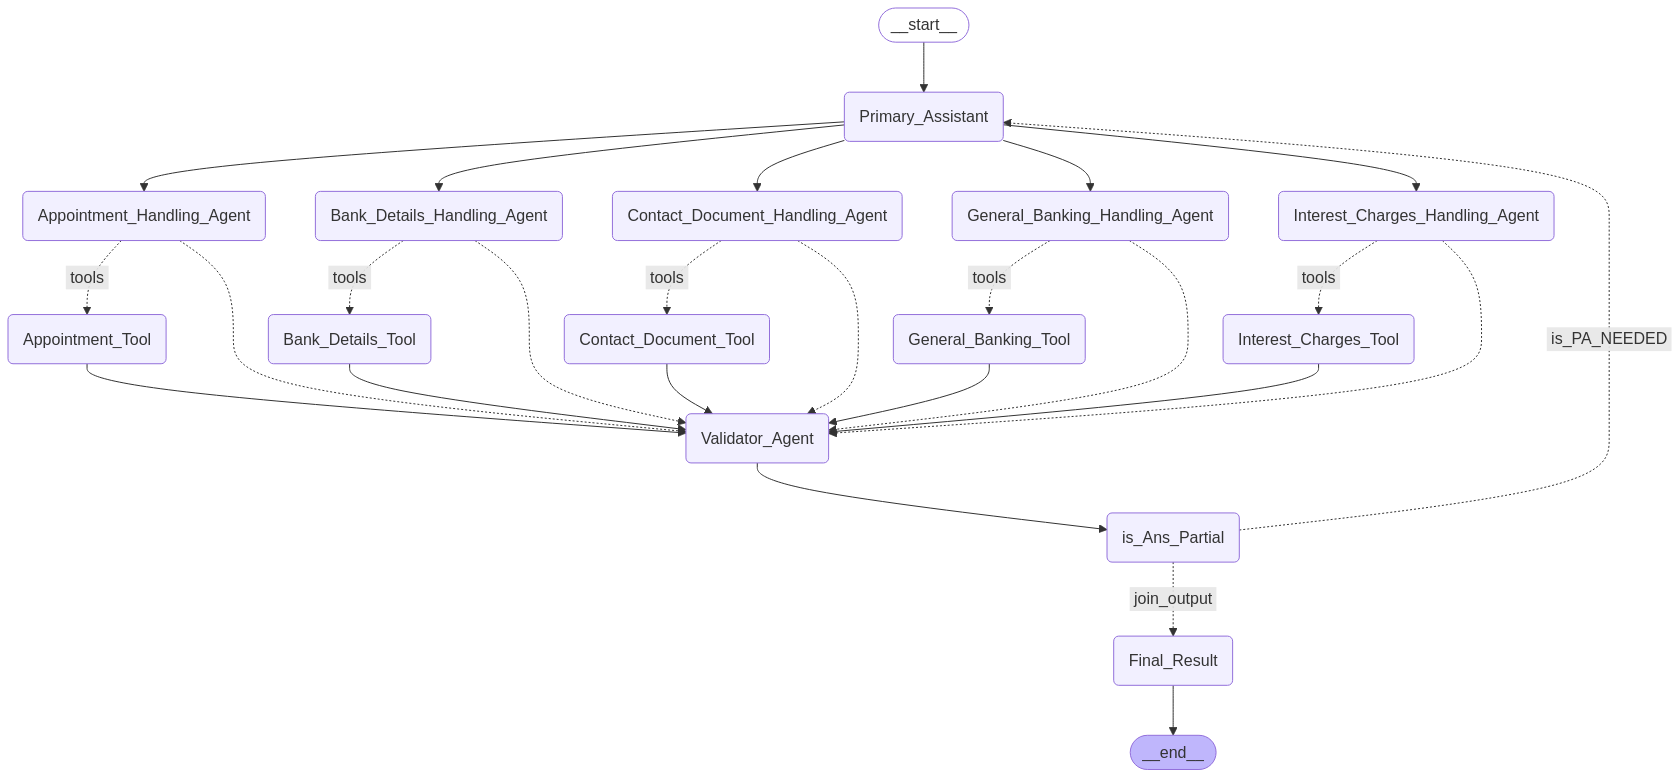

In [47]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [48]:
response = graph.invoke({"messages": [HumanMessage(content="who is ceo",name="user")]})

>>>>>>>>>>>>>>>>>> Interest_Charges_Handling_Agent Running <<<<<<<<<<<<<<<<<<<<<<
>>>>>>>>>>>>>>>>>> Contact_Document_Handling_Agent Running <<<<<<<<<<<<<<<<<<<<<<
>>>>>>>>>>>>>>>>>> General_Banking_Handling_Agent Running <<<<<<<<<<<<<<<<<<<<<<
>>>>>>>>>>>>>>>>>> Bank_Details_Handling_Agent Running <<<<<<<<<<<<<<<<<<<<<<
>>>>>>>>>>>>>>>>>> Appointment_Handling_Agent Running <<<<<<<<<<<<<<<<<<<<<<


TypeError: can only concatenate list (not "str") to list

In [ ]:
response

{'processed_questions': [],
 'orginal_question': ['who is ceo and how to get atm card how to take loan',
  'how to get atm card how to take loan'],
 'messages': [HumanMessage(content='How to take loan?', additional_kwargs={}, response_metadata={}, name='user', id='dcf01b63-629c-414a-a2e2-539f1f4182c0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4XZSoQS1egTLxKOvj1yE2VZg', 'function': {'arguments': '{"query":"How to take loan?"}', 'name': 'general-banking-tool'}, 'type': 'function'}]}, response_metadata={}, id='6816daeb-0e08-4e9e-854b-09be8d7fd284', tool_calls=[{'name': 'general-banking-tool', 'args': {'query': 'How to take loan?'}, 'id': 'call_4XZSoQS1egTLxKOvj1yE2VZg', 'type': 'tool_call'}]),
  ToolMessage(content='none', name='general-banking-tool', id='7ef2dccf-aad3-48fa-9d1f-328745f1f83f', tool_call_id='call_4XZSoQS1egTLxKOvj1yE2VZg')],
 'direction': '',
 'need_to_reload': 'no',
 'loop': '',
 'store': ['Pradyuman Pokharel is the CEO.', "I don't know", "I

In [ ]:
print(response['Final_Output'])

Hello! Thank you for reaching out. Pradyuman Pokharel is the CEO. If you have any specific questions about getting an ATM card or taking out a loan, feel free to ask, and I'll do my best to assist you!
